Notebook to analyse user data

In [1]:
import yaml
import os
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import inspect

In [2]:
from mrdc import database_utils
from mrdc import data_extraction
from mrdc import data_cleaning

    

In [3]:
base_path = r"C:\Users\abhik\Documents\aicore\multinational-retail-data-centralisation946"
data_connector = database_utils.DatabaseConnector(base_path=base_path, cred_file="db_creds.yaml")
data_extractor = data_extraction.DataExtractor()
data_connector.list_db_table()


['legacy_store_details', 'legacy_users', 'orders_table']

In [4]:
data_df = data_extractor.read_rds_table(data_connector, table_name="legacy_users")
data_df.head()

,index,first_name,last_name,date_of_birth,company,email_address,address,country,country_code,phone_number,join_date,user_uuid
0,0,Sigfried,Noack,1990-09-30,Heydrich Junitz KG,rudi79@winkler.de,Zimmerstr. 1/0\n59015 Gießen,Germany,DE,+49(0) 047905356,2018-10-10,93caf182-e4e9-4c6e-bebb-60a1a9dcf9b8
1,1,Guy,Allen,1940-12-01,Fox Ltd,rhodesclifford@henderson.com,Studio 22a\nLynne terrace\nMcCarthymouth\nTF0 9GH,United Kingdom,GB,(0161) 496 0674,2001-12-20,8fe96c3a-d62d-4eb5-b313-cf12d9126a49
2,2,Harry,Lawrence,1995-08-02,"Johnson, Jones and Harris",glen98@bryant-marshall.co.uk,92 Ann drive\nJoanborough\nSK0 6LR,United Kingdom,GB,+44(0)121 4960340,2016-12-16,fc461df4-b919-48b2-909e-55c95a03fe6b
3,3,Darren,Hussain,1972-09-23,Wheeler LLC,daniellebryan@thompson.org,19 Robinson meadow\nNew Tracy\nW22 2QG,United Kingdom,GB,(0306) 999 0871,2004-02-23,6104719f-ef14-4b09-bf04-fb0c4620acb0
4,4,Garry,Stone,1952-12-20,Warner Inc,billy14@long-warren.com,3 White pass\nHunterborough\nNN96 4UE,United Kingdom,GB,0121 496 0225,2006-09-01,9523a6d3-b2dd-4670-a51a-36aebc89f579


In [5]:
data_df.shape

(15320, 12)

In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15320 entries, 0 to 15319
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          15320 non-null  int64 
 1   first_name     15320 non-null  object
 2   last_name      15320 non-null  object
 3   date_of_birth  15320 non-null  object
 4   company        15320 non-null  object
 5   email_address  15320 non-null  object
 6   address        15320 non-null  object
 7   country        15320 non-null  object
 8   country_code   15320 non-null  object
 9   phone_number   15320 non-null  object
 10  join_date      15320 non-null  object
 11  user_uuid      15320 non-null  object
dtypes: int64(1), object(11)
memory usage: 1.4+ MB


In [7]:
data_df["country"].value_counts()

United Kingdom    9371
Germany           4708
United States     1205
NULL                21
GMRBOMI0O1           1
7ZNO5EBALT           1
3518UD5CE8           1
RQRB7RMTAD           1
PNRMPSYR1J           1
5EFAFD0JLI           1
YOTSVPRBQ7           1
50KUU3PQUF           1
EWE3U0DZIV           1
XN9NGL5C0B           1
S0E37H52ON           1
XGI7FM0VBJ           1
AJ1ENKS3QL           1
I7G4DMDZOZ           1
T4WBZSW0XI           1
Name: country, dtype: int64

In [8]:
data_df = data_df[~data_df.isin(["NULL"]).any(axis=1)]

In [9]:
data_df.shape

(15299, 12)

In [10]:
data_df = data_df[~data_df["country"].str.contains(r'[0-9]')]

In [11]:
data_df["country"].value_counts()

United Kingdom    9371
Germany           4708
United States     1205
Name: country, dtype: int64

In [12]:
data_df["country_code"].value_counts()

GB     9365
DE     4708
US     1205
GGB       6
Name: country_code, dtype: int64

In [13]:
data_df['country_code'] = data_df['country_code'].str.replace('GGB', 'GB')

In [14]:
data_df["country_code"].value_counts()

GB    9371
DE    4708
US    1205
Name: country_code, dtype: int64

In [15]:
data_df.shape

(15284, 12)

In [16]:
data_df = data_df[~data_df["first_name"].str.contains(r'[0-9]')]

In [17]:
data_df.shape

(15284, 12)

In [18]:
data_df = data_df[~data_df["last_name"].str.contains(r'[0-9]')]

In [19]:
data_df.shape

(15284, 12)

In [20]:
import re
pattern = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'

# filter out valid emails using str.contains()
valid_emails = data_df["email_address"].str.contains(pattern)
data_df = data_df[valid_emails]

In [21]:
data_df.shape

(15242, 12)

In [22]:
data_df.head()

,index,first_name,last_name,date_of_birth,company,email_address,address,country,country_code,phone_number,join_date,user_uuid
0,0,Sigfried,Noack,1990-09-30,Heydrich Junitz KG,rudi79@winkler.de,Zimmerstr. 1/0\n59015 Gießen,Germany,DE,+49(0) 047905356,2018-10-10,93caf182-e4e9-4c6e-bebb-60a1a9dcf9b8
1,1,Guy,Allen,1940-12-01,Fox Ltd,rhodesclifford@henderson.com,Studio 22a\nLynne terrace\nMcCarthymouth\nTF0 9GH,United Kingdom,GB,(0161) 496 0674,2001-12-20,8fe96c3a-d62d-4eb5-b313-cf12d9126a49
2,2,Harry,Lawrence,1995-08-02,"Johnson, Jones and Harris",glen98@bryant-marshall.co.uk,92 Ann drive\nJoanborough\nSK0 6LR,United Kingdom,GB,+44(0)121 4960340,2016-12-16,fc461df4-b919-48b2-909e-55c95a03fe6b
3,3,Darren,Hussain,1972-09-23,Wheeler LLC,daniellebryan@thompson.org,19 Robinson meadow\nNew Tracy\nW22 2QG,United Kingdom,GB,(0306) 999 0871,2004-02-23,6104719f-ef14-4b09-bf04-fb0c4620acb0
4,4,Garry,Stone,1952-12-20,Warner Inc,billy14@long-warren.com,3 White pass\nHunterborough\nNN96 4UE,United Kingdom,GB,0121 496 0225,2006-09-01,9523a6d3-b2dd-4670-a51a-36aebc89f579


In [23]:
pattern_numeric = r'[0-9]'

# filter out valid emails using str.contains()
valid_phone_number = data_df["phone_number"].str.contains(pattern_numeric)
data_df = data_df[valid_phone_number]

In [24]:
data_df.head()

,index,first_name,last_name,date_of_birth,company,email_address,address,country,country_code,phone_number,join_date,user_uuid
0,0,Sigfried,Noack,1990-09-30,Heydrich Junitz KG,rudi79@winkler.de,Zimmerstr. 1/0\n59015 Gießen,Germany,DE,+49(0) 047905356,2018-10-10,93caf182-e4e9-4c6e-bebb-60a1a9dcf9b8
1,1,Guy,Allen,1940-12-01,Fox Ltd,rhodesclifford@henderson.com,Studio 22a\nLynne terrace\nMcCarthymouth\nTF0 9GH,United Kingdom,GB,(0161) 496 0674,2001-12-20,8fe96c3a-d62d-4eb5-b313-cf12d9126a49
2,2,Harry,Lawrence,1995-08-02,"Johnson, Jones and Harris",glen98@bryant-marshall.co.uk,92 Ann drive\nJoanborough\nSK0 6LR,United Kingdom,GB,+44(0)121 4960340,2016-12-16,fc461df4-b919-48b2-909e-55c95a03fe6b
3,3,Darren,Hussain,1972-09-23,Wheeler LLC,daniellebryan@thompson.org,19 Robinson meadow\nNew Tracy\nW22 2QG,United Kingdom,GB,(0306) 999 0871,2004-02-23,6104719f-ef14-4b09-bf04-fb0c4620acb0
4,4,Garry,Stone,1952-12-20,Warner Inc,billy14@long-warren.com,3 White pass\nHunterborough\nNN96 4UE,United Kingdom,GB,0121 496 0225,2006-09-01,9523a6d3-b2dd-4670-a51a-36aebc89f579


In [25]:
data_df.isnull().sum()

index            0
first_name       0
last_name        0
date_of_birth    0
company          0
email_address    0
address          0
country          0
country_code     0
phone_number     0
join_date        0
user_uuid        0
dtype: int64

In [26]:
data_df.isna().sum()

index            0
first_name       0
last_name        0
date_of_birth    0
company          0
email_address    0
address          0
country          0
country_code     0
phone_number     0
join_date        0
user_uuid        0
dtype: int64

In [27]:
if pd.to_datetime(data_df['date_of_birth'], format='%Y-%m-%d', errors='coerce').notnull().all():
    print("no error")
else:
    print("wrong date format present")
    

wrong date format present


In [28]:
try:
    pd.to_datetime(data_df['date_of_birth'], format='%Y-%m-%d', errors="raise")
except ValueError as e:
    print(e)

time data "1968 October 16" at position 359 doesn't match format specified


In [29]:
nan_df = pd.to_datetime(data_df['date_of_birth'], format='%Y-%m-%d', errors="coerce")
# above will return NaN when the format not match 
clean_df = data_df[nan_df.notna()]

In [30]:
pd.to_datetime(clean_df['date_of_birth'], format='%Y-%m-%d')

0       1990-09-30
1       1940-12-01
2       1995-08-02
3       1972-09-23
4       1952-12-20
           ...    
15315   1943-08-09
15316   1948-08-20
15317   1940-10-09
15318   1952-06-04
15319   1994-03-27
Name: date_of_birth, Length: 15226, dtype: datetime64[ns]

In [31]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15226 entries, 0 to 15319
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          15226 non-null  int64 
 1   first_name     15226 non-null  object
 2   last_name      15226 non-null  object
 3   date_of_birth  15226 non-null  object
 4   company        15226 non-null  object
 5   email_address  15226 non-null  object
 6   address        15226 non-null  object
 7   country        15226 non-null  object
 8   country_code   15226 non-null  object
 9   phone_number   15226 non-null  object
 10  join_date      15226 non-null  object
 11  user_uuid      15226 non-null  object
dtypes: int64(1), object(11)
memory usage: 1.5+ MB


In [32]:

data_df.describe()


,index
count,15242.000000
mean,7659.406508
std,4423.553882
min,0.000000
25%,3829.250000
50%,7659.500000
75%,11490.750000
max,15319.000000


In [33]:

data_df["company"].unique()

array(['Heydrich Junitz KG', 'Fox Ltd', 'Johnson, Jones and Harris', ...,
       'Robinson-Harris', 'Taylor, Fry and Jones',
       'Phillips, Brown and Powell'], dtype=object)

In [34]:
pdf_df= data_extractor.retrieve_pdf_data("https://data-handling-public.s3.eu-west-1.amazonaws.com/card_details.pdf")


In [35]:
pdf_df.head()

,card_number,expiry_date,card_provider,date_payment_confirmed
0,30060773296197,09/26,Diners Club / Carte Blanche,2015-11-25
1,349624180933183,10/23,American Express,2001-06-18
2,3529023891650490,06/23,JCB 16 digit,2000-12-26
3,213142929492281,09/27,JCB 15 digit,2011-02-12
4,502067329974,10/25,Maestro,1997-03-13


In [36]:
pdf_df.shape

(15309, 4)

In [37]:
pdf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15309 entries, 0 to 18
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   card_number             15309 non-null  object
 1   expiry_date             15309 non-null  object
 2   card_provider           15309 non-null  object
 3   date_payment_confirmed  15309 non-null  object
dtypes: object(4)
memory usage: 598.0+ KB


In [38]:
pdf_df.isna().sum()

card_number               0
expiry_date               0
card_provider             0
date_payment_confirmed    0
dtype: int64

In [39]:
pdf_df.describe()

,card_number,expiry_date,card_provider,date_payment_confirmed
count,15309,15309,15309,15309
unique,15299,136,25,8270
top,NULL,03/28,VISA 16 digit,NULL
freq,11,163,2426,11


In [40]:
pdf_df.isnull().sum()

card_number               0
expiry_date               0
card_provider             0
date_payment_confirmed    0
dtype: int64

In [41]:
try:
    pd.to_datetime(pdf_df['date_payment_confirmed'], format='%Y-%m-%d', errors="raise")
except ValueError as e:
    print(e)

time data "NULL" at position 377 doesn't match format specified


In [42]:
pdf_df.iloc[[377]]

,card_number,expiry_date,card_provider,date_payment_confirmed
47,NULL,NULL,NULL,NULL


In [43]:
pdf_df[pdf_df['card_provider'].str.contains("NULL")]

,card_number,expiry_date,card_provider,date_payment_confirmed
47,NULL,NULL,NULL,NULL
22,NULL,NULL,NULL,NULL
4,NULL,NULL,NULL,NULL
53,NULL,NULL,NULL,NULL
14,NULL,NULL,NULL,NULL
25,NULL,NULL,NULL,NULL
16,NULL,NULL,NULL,NULL
21,NULL,NULL,NULL,NULL
29,NULL,NULL,NULL,NULL
6,NULL,NULL,NULL,NULL


In [44]:
pdf_df_clean = pdf_df[~pdf_df.isin(["NULL"]).any(axis=1)]

In [45]:
try:
    pd.to_datetime(pdf_df_clean['date_payment_confirmed'], format='%Y-%m-%d', errors="raise")
except ValueError as e:
    print(e)

time data "GTC9KBWJO9" at position 826 doesn't match format specified


In [46]:
nan_df = pd.to_datetime(pdf_df_clean['date_payment_confirmed'], format='%Y-%m-%d', errors="coerce")
pdf_df_clean_date = pdf_df_clean[nan_df.notna()]

In [47]:
pdf_df_clean_date.head()

,card_number,expiry_date,card_provider,date_payment_confirmed
0,30060773296197,09/26,Diners Club / Carte Blanche,2015-11-25
1,349624180933183,10/23,American Express,2001-06-18
2,3529023891650490,06/23,JCB 16 digit,2000-12-26
3,213142929492281,09/27,JCB 15 digit,2011-02-12
4,502067329974,10/25,Maestro,1997-03-13


In [48]:
try:
    pd.to_datetime(pdf_df_clean_date['date_payment_confirmed'], format='%Y-%m-%d', errors="raise")
except ValueError as e:
    print(e)

In [49]:
try:
    pd.to_datetime(pdf_df_clean_date['expiry_date'], format='%m/%d', errors="raise")
except ValueError as e:
    print(e)

day is out of range for month


In [50]:
pdf_df_clean_date.shape

(15277, 4)

In [51]:
nan_df_expiry = pd.to_datetime(pdf_df_clean_date['expiry_date'], format='%m/%d', errors="coerce")
pdf_df_clean_date_expiry = pdf_df_clean_date[nan_df_expiry.notna()]

In [52]:
pdf_df_clean_date_expiry.shape

(13146, 4)

In [53]:
pdf_df_clean_date_expiry["card_provider"].unique()

array(['Diners Club / Carte Blanche', 'American Express', 'JCB 16 digit',
       'JCB 15 digit', 'Maestro', 'Discover', 'Mastercard',
       'VISA 19 digit', 'VISA 16 digit', 'VISA 13 digit'], dtype=object)

<AxesSubplot:>

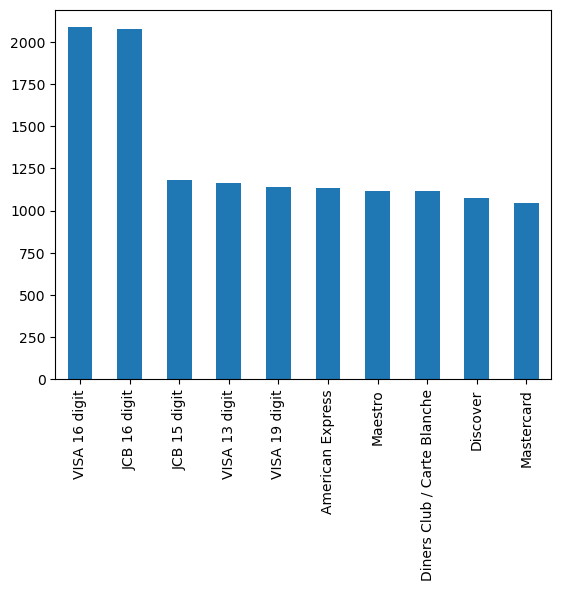

In [54]:
pdf_df_clean_date_expiry["card_provider"].value_counts().plot(kind="bar")

In [55]:
pdf_df_clean_date_expiry['card_number'].str.contains('[^a-zA-Z]')

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
     ... 
13    NaN
14    NaN
15    NaN
16    NaN
17    NaN
Name: card_number, Length: 13146, dtype: object

In [56]:
pdf_df_clean_date_expiry.head()

,card_number,expiry_date,card_provider,date_payment_confirmed
0,30060773296197,09/26,Diners Club / Carte Blanche,2015-11-25
1,349624180933183,10/23,American Express,2001-06-18
2,3529023891650490,06/23,JCB 16 digit,2000-12-26
3,213142929492281,09/27,JCB 15 digit,2011-02-12
4,502067329974,10/25,Maestro,1997-03-13


In [57]:
pdf_df_clean_date_expiry.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13146 entries, 0 to 17
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   card_number             13146 non-null  object
 1   expiry_date             13146 non-null  object
 2   card_provider           13146 non-null  object
 3   date_payment_confirmed  13146 non-null  object
dtypes: object(4)
memory usage: 513.5+ KB


In [58]:
pattern_numeric = r'[0-9]'

# filter out valid emails using str.contains()
valid_card_number = pdf_df_clean_date_expiry["card_number"].str.contains(pattern_numeric, na=False)
pdf_df_final  = pdf_df_clean_date_expiry[valid_card_number]

In [59]:
pdf_df_final.head()

,card_number,expiry_date,card_provider,date_payment_confirmed
0,4145662949755970,10/25,VISA 16 digit,2019-01-30
3,6011887212979720,07/29,Discover,1996-04-05
4,6011592595426290,05/26,Discover,1993-04-27
5,213164174481249,08/29,JCB 15 digit,2020-04-22
6,6521667118670950,01/28,Discover,2008-12-04


In [60]:
import requests


In [61]:
def get_api_response(url, headers_dict):
    response = requests.get(url, headers_dict)
    return response.json()

In [62]:
headers_dict = {
        "Content-Type": "application/json", 
        "x-api-key": "yFBQbwXe9J3sd6zWVAMrK6lcxxr0q1lr2PT6DDMX"
        }
response = requests.get("https://aqj7u5id95.execute-api.eu-west-1.amazonaws.com/prod/number_stores", headers=headers_dict)
p = response.json()
p["number_stores"]


451

In [110]:
list_of_dict= []
for i in range(451):
    uri = f"https://aqj7u5id95.execute-api.eu-west-1.amazonaws.com/prod/store_details/{i}"
    response = requests.get(uri, headers=headers_dict)
    list_of_dict.append(response.json())

In [96]:
import pandas as pd
store_df = pd.DataFrame(list_of_dict)

In [97]:
store_df.head()

,index,address,longitude,lat,locality,store_code,staff_numbers,opening_date,store_type,latitude,country_code,continent
0,0,N/A,N/A,N/A,N/A,WEB-1388012W,325,2010-06-12,Web Portal,None,GB,Europe
1,1,"Flat 72W\nSally isle\nEast Deantown\nE7B 8EB, ...",51.62907,None,High Wycombe,HI-9B97EE4E,34,1996-10-25,Local,-0.74934,GB,Europe
2,2,"Heckerstraße 4/5\n50491 Säckingen, Landshut",48.52961,None,Landshut,LA-0772C7B9,92,2013-04-12,Super Store,12.16179,DE,Europe
3,3,"5 Harrison tunnel\nSouth Lydia\nWC9 2BE, Westbury",51.26,None,Westbury,WE-1DE82CEE,69,2014-01-02,Super Store,-2.1875,GB,Europe
4,4,Studio 6\nStephen landing\nSouth Simon\nB77 2W...,53.0233,None,Belper,BE-18074576,35,2019-09-09,Local,-1.48119,GB,Europe


In [109]:
store_df[store_df["store_code"].str.contains("WEB")]

,index,address,longitude,lat,locality,store_code,staff_numbers,opening_date,store_type,latitude,country_code,continent
0,0,N/A,N/A,N/A,N/A,WEB-1388012W,325,2010-06-12,Web Portal,None,GB,Europe


In [66]:
store_df.shape

(451, 12)

In [67]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          451 non-null    int64 
 1   address        451 non-null    object
 2   longitude      451 non-null    object
 3   lat            11 non-null     object
 4   locality       451 non-null    object
 5   store_code     451 non-null    object
 6   staff_numbers  451 non-null    object
 7   opening_date   451 non-null    object
 8   store_type     451 non-null    object
 9   latitude       450 non-null    object
 10  country_code   451 non-null    object
 11  continent      451 non-null    object
dtypes: int64(1), object(11)
memory usage: 42.4+ KB


In [68]:
store_df = store_df[~store_df.isin(["N/A"]).any(axis=1)]

In [69]:
store_df = store_df[~store_df.isin(["NULL"]).any(axis=1)]

In [70]:
store_df.head()

,index,address,longitude,lat,locality,store_code,staff_numbers,opening_date,store_type,latitude,country_code,continent
1,1,"Flat 72W\nSally isle\nEast Deantown\nE7B 8EB, ...",51.62907,None,High Wycombe,HI-9B97EE4E,34,1996-10-25,Local,-0.74934,GB,Europe
2,2,"Heckerstraße 4/5\n50491 Säckingen, Landshut",48.52961,None,Landshut,LA-0772C7B9,92,2013-04-12,Super Store,12.16179,DE,Europe
3,3,"5 Harrison tunnel\nSouth Lydia\nWC9 2BE, Westbury",51.26,None,Westbury,WE-1DE82CEE,69,2014-01-02,Super Store,-2.1875,GB,Europe
4,4,Studio 6\nStephen landing\nSouth Simon\nB77 2W...,53.0233,None,Belper,BE-18074576,35,2019-09-09,Local,-1.48119,GB,Europe
5,5,Flat 92u\nChristian harbors\nPort Charlotte\nN...,53.38333,None,Gainsborough,GA-CAD01AC2,36,1995-05-15,Local,-0.76667,GB,Europe


In [71]:
store_df.drop(["lat"], inplace=True, axis=1)

In [72]:
store_df.shape

(447, 11)

In [73]:
store_df["country_code"].value_counts()

GB            265
DE            141
US             34
YELVM536YT      1
FP8DLXQVGH      1
HMHIFNLOBN      1
F3AO8V2LHU      1
OH20I92LX3      1
OYVW925ZL8      1
B3EH2ZGQAV      1
Name: country_code, dtype: int64

In [74]:
store_df = store_df[~(store_df["country_code"].str.contains(r'[0-9]'))]


In [75]:
store_df = store_df[~(store_df["country_code"].str.len() > 2)]

In [76]:
store_df["store_type"].value_counts()

Local          255
Super Store     89
Mall Kiosk      51
Outlet          45
Name: store_type, dtype: int64

In [77]:
store_df["continent"].unique()

array(['Europe', 'America', 'eeEurope', 'eeAmerica'], dtype=object)

In [78]:
store_df['continent'] = store_df['continent'].str.replace('ee', '')


In [79]:
store_df["continent"].value_counts()    

Europe     406
America     34
Name: continent, dtype: int64

In [80]:
store_df["store_code"].value_counts()

HI-9B97EE4E    1
BR-CACF7508    1
GA-D570038A    1
CH-7638016B    1
GI-718674C0    1
              ..
SU-5F78B30A    1
CL-DA5365DF    1
ME-9940FF73    1
BU-5B54171E    1
BA-B4AED588    1
Name: store_code, Length: 440, dtype: int64

In [81]:
try:
    pd.to_datetime(store_df['opening_date'], format='%Y-%m-%d', errors="raise")
except ValueError as e:
    print(e)

time data "October 2012 08" at position 9 doesn't match format specified


In [82]:
store_df["locality"].unique()

array(['High Wycombe', 'Landshut', 'Westbury', 'Belper', 'Gainsborough',
       'Rutherglen', 'Stuttgart', 'Kaukauna', 'Hartley', 'Siegburg',
       'Devizes', 'Crystal Lake', 'Halstenbek', 'Lancing', 'Newbury',
       'Lymington', 'Chapletown', 'Barnet', 'East Dereham',
       'Poulton-le-Fylde', 'Bushey', 'Ehingen', 'Aberdeen', 'Surbiton',
       'Inverness', 'Weimar', 'Penzance', 'Albstadt', 'Hechingen',
       'Mexborough', 'Arbroath', 'Cowes', 'Clacton-on-Sea', 'Boston',
       'Charlottenburg-Nord', 'Bretten', 'Sun City Center', 'Karben',
       'Martinsburg', 'Oschatz', 'Kingston upon Hull', 'Leyland',
       'Venice', 'Schleswig', 'Eppingen', 'Losheim', 'Burscheid',
       'Southsea', 'Porterville', 'Walsrode', 'Exeter', 'Thetford',
       'Morningside Heights', 'Searcy', 'Radevormwald', 'Stade',
       'Mira Mesa', 'Strood', 'Verl', 'Wesseling', 'Pfullingen',
       'Bensheim', 'Walton-on-the-Naze', 'Friedberg', 'Winsford',
       'Newburgh', 'Selby', 'Oberhausen', 'Zeitz', 'V

In [83]:
from mrdc import database_utils
import os

In [84]:
base_path = os.getcwd()


In [85]:
aws_data_connector = database_utils.DatabaseConnector(base_path=base_path, cred_file="db_creds.yaml")


In [86]:
all_tables = aws_data_connector.list_db_table()
for table in all_tables:
    print(table)

legacy_store_details
legacy_users
orders_table


In [122]:
order_df = data_extractor.read_rds_table(data_connector, table_name="orders_table")


In [123]:
order_df.head()

,level_0,index,date_uuid,first_name,last_name,user_uuid,card_number,store_code,product_code,1,product_quantity
0,0,0,9476f17e-5d6a-4117-874d-9cdb38ca1fa6,None,None,93caf182-e4e9-4c6e-bebb-60a1a9dcf9b8,30060773296197,BL-8387506C,R7-3126933h,NaN,3
1,1,1,0423a395-a04d-4e4a-bd0f-d237cbd5a295,None,None,8fe96c3a-d62d-4eb5-b313-cf12d9126a49,349624180933183,WEB-1388012W,C2-7287916l,NaN,2
2,2,2,65187294-bb16-4519-adc0-787bbe423970,None,None,fc461df4-b919-48b2-909e-55c95a03fe6b,3529023891650490,CH-01D85C8D,S7-1175877v,NaN,2
3,3,3,579e21f7-13cb-436b-83ad-33687a4eb337,None,None,6104719f-ef14-4b09-bf04-fb0c4620acb0,213142929492281,CL-C183BE4B,D8-8421505n,NaN,2
4,4,4,00ab86c3-2039-4674-b9c1-adbcbbf525bd,None,None,9523a6d3-b2dd-4670-a51a-36aebc89f579,502067329974,SO-B5B9CB3B,B6-2596063a,NaN,2


In [124]:
order_df.shape

(120123, 11)

In [125]:
order_df = order_df[~order_df.isin(["N/A"]).any(axis=1)]

In [108]:
order_df[order_df["store_code"].str.contains('WEB')]

,level_0,index,date_uuid,first_name,last_name,user_uuid,card_number,store_code,product_code,1,product_quantity
1,1,1,0423a395-a04d-4e4a-bd0f-d237cbd5a295,None,None,8fe96c3a-d62d-4eb5-b313-cf12d9126a49,349624180933183,WEB-1388012W,C2-7287916l,NaN,2
5,5,5,c3a1df8f-6918-4795-9f8a-6869b2cda9cf,Brett,Welch,53d21f46-1fa4-452f-a023-26aee2aae4d6,3506661913512980,WEB-1388012W,g3-7974400s,NaN,2
8,8,8,38ebd7b6-b1d4-462e-bfd7-265e3674ef3f,Marion,Stokes,02de2416-4baf-42ad-bae6-d716eca0fc3f,6011037917693140,WEB-1388012W,i4-2651057I,NaN,5
11,11,11,2e78a288-31c6-4a2a-8aea-cb93ad389aaa,Kreszentia,Hornich,bf86d13b-882b-485e-addd-0c4e9a39a96c,6502495513721380,WEB-1388012W,S6-3678717g,NaN,1
12,12,12,0e1e7e2b-ba00-4c47-9daf-d8f527086f76,None,None,52717e6a-955c-4c16-8f25-9e6a71ba3f60,3551071736826240,WEB-1388012W,Z2-0851042W,NaN,8
...,...,...,...,...,...,...,...,...,...,...,...
120106,53055,53054,826fcd34-2886-493b-9f05-071c0c73bb8c,Lee,Thomas,a2ddc7d8-3434-4a3d-920f-17befdee38a3,4971858637664481,WEB-1388012W,V2-1615331d,NaN,4
120107,59862,59862,2e38823a-fbcb-4fc5-94bf-8457417c1d20,None,None,d48a254d-dd98-471e-a506-622f30774009,4971858637664481,WEB-1388012W,x6-9994287R,NaN,4
120110,77538,77538,1f049481-3fa2-498b-8a60-66b60a71d376,Friedemann,Jüttner,2e5d948f-3a52-42c5-ab33-3a162208915b,4971858637664481,WEB-1388012W,o6-5976806E,NaN,2
120114,81466,81466,9e4b398e-c733-41d8-b28e-95550b0f1e41,None,None,61aece9d-de6d-442f-a30b-fb4c63559202,575421945446,WEB-1388012W,r3-37753L,NaN,3


In [126]:
order_df.shape

(120123, 11)

In [179]:
import boto3

In [180]:
s3 = boto3.client('s3')

In [181]:
df = pd.read_csv('s3://data-handling-public/products.csv')

In [182]:
df.head(1)

,Unnamed: 0,product_name,product_price,weight,category,EAN,date_added,uuid,removed,product_code
0,0,FurReal Dazzlin' Dimples My Playful Dolphin,£39.99,1.6kg,toys-and-games,7425710935115,2005-12-02,83dc0a69-f96f-4c34-bcb7-928acae19a94,Still_avaliable,R7-3126933h


In [183]:
df.shape

(1853, 10)

In [136]:
df.dropna(inplace=True)

In [137]:
df.shape

(1849, 10)

In [145]:
import numpy as np

In [132]:
df["weight"].unique()

array(['1.6kg', '0.48kg', '590g', '540g', '1.91kg', '0.91kg', '0.46kg',
       '0.38kg', '8.981kg', '1.478kg', '1.2g', '0.66kg', '1.8kg', '1.9kg',
       '1.725kg', '0.54kg', '0.322kg', '0.71kg', '0.88kg', '0.67kg',
       '11.076kg', '4kg', '0.385kg', '1.38kg', '2.57kg', '1.35kg',
       '0.695kg', '1.15kg', '0.98kg', '1.447kg', '1.3625kg', '2.25kg',
       '0.79kg', '0.8kg', '1.08kg', '2.476kg', '0.137kg', '11.5kg',
       '0.44kg', '2.75kg', '0.911kg', '0.33kg', '1kg', '0.5kg', '0.45kg',
       '0.7kg', '0.41kg', '1.3kg', '2kg', '0.34kg', '0.37kg', '0.76kg',
       '1.18kg', '0.685kg', '1.59kg', '1.4kg', '1.66kg', '13.5kg',
       '0.745kg', '1.44kg', '0.74kg', '0.660kg', '0.419kg', '0.418kg',
       '0.470kg', '0.353kg', '0.350kg', '0.96kg', '1.20kg', '1.21kg',
       '1.02kg', '0.365kg', '0.677kg', '0.55kg', '0.43kg', '0.11kg',
       '1.23kg', '1.03kg', '0.87kg', '0.39kg', '0.35kg', '0.42kg',
       '0.27kg', '726g', '0.61kg', '0.864kg', '0.667kg', '0.63kg',
       '0.72kg', '0.5

In [184]:
def _convert_product_weights(product: str) -> float:
    """ This method will convert the product weights
    :param product:
    :return:
    """
    if "kg" in product:
        product = product.split("kg")[0]
        product = float(product)
    elif "g" in product and "x" not in product:
        product = product.split("g")[0]
        product = float(product) / 1000
    elif "ml" in product:
        product = product.split("ml")[0]
        product = float(product) / 1000
    elif "oz" in product:
        product = product.split("oz")[0]
        product = float(product) * 0.0283495
    elif "x" in product:
        product = product.split("x")
        product = (float(product[0].strip())) * float(product[1].strip().replace("g", "")) / 1000
    else:
        product = np.nan
    return product


In [177]:
df_heavy = df.loc[(df["weight_mod"] > 40) & (df["weight_mod"] < 140)]

In [178]:
df_heavy.head(100)

,Unnamed: 0,product_name,product_price,weight,category,EAN,date_added,uuid,removed,product_code,weight_mod


In [160]:
import seaborn as sns

<AxesSubplot:>

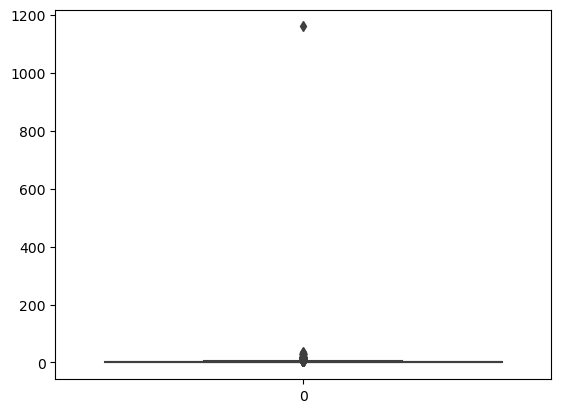

In [162]:
sns.boxplot(df["weight_mod"])

In [163]:
df.describe()

,Unnamed: 0,weight_mod
count,1849.000000,1846.000000
mean,926.106003,3.004291
std,535.127254,27.300464
min,0.000000,0.000944
25%,463.000000,0.270000
50%,927.000000,0.718000
75%,1389.000000,2.060000
max,1852.000000,1160.000000


In [169]:
df.dropna(inplace=True)

In [171]:
df.shape

(1846, 11)

In [170]:
df.to_csv("products.csv", index=False)